# Input Parameters

In [1]:
# This parameters cell will be overridden by values specified at execution time.
sample_name = "pbmc_1k"
path_raw_adata = "../test/pbmc_1k.raw.h5ad"
path_filtered_adata = "../test/pbmc_1k.filtered.h5ad"

path_outdir = "./outputs/"
path_rb_gene_list = "./RB_genes_human.txt"

# fixme: load from a file
markers = []

# Imports and Functions

## Imports

In [2]:
import warnings
import difflib
import phenograph
import time
import timeit
from copy import deepcopy
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
import scipy
import scipy.io
import scipy.sparse as sp
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import os
from get_optimal_k import KOptimizer

import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
sbn.set()
np.random.seed(0)

# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
os.makedirs(path_outdir, exist_ok=True)

## Functions

### Utilities

In [4]:
def get_PCA_var(adata, N):

    adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    variance = adata_new.uns['pca']['variance_ratio']
    cum_variance = np.cumsum(variance) # cumulative variance explained

    return adata_new, variance, cum_variance


def plot_PCA(adata, N = 100):

    N = np.min([N, adata.shape[0], adata.shape[1]])
    adata_new, var, cum_var = get_PCA_var(adata, N)

    fig, axes = plt.subplots(1,2, figsize = (14, 5))
    ax1, ax2 = axes
    
    #Plot variance explained
    x = np.linspace(0, N, N)
    y = var
    ax1.scatter(x,y,s=4)
    ax1.set_xlabel('PC')
    ax1.set_ylabel('Fraction of variance explained')
    ax1.set_title('Fraction of variance explained per PC')
    
    #Plot cumulative variance
    x = x
    y = cum_var
    ax2.scatter(x,y,s=4)
    ax2.set_xlabel('PC')
    ax2.set_ylabel('Cumulative fraction of variance explained')
    ax2.set_title('Cumulative fraction of variance explained by PCs')
    
    plt.show()
    
    return adata_new, var, cum_var


def kneepoint(vals):

    # Convert array of values to 2D vectors by position in array
    vals = np.array(vals)
    descending = vals[-1] < vals[0]
    if descending: vals = -vals #Should go from 0 to 1
    n_pts = vals.shape[0]
    xcoords = range(n_pts)
    pts = np.vstack([xcoords, vals]).T

    last_vec = pts[-1] - pts[0] # Get vec b/n first and last points
    last_vec_norm = last_vec/np.linalg.norm(last_vec) # L2 normalized vector
    all_vecs = pts - pts[0] # Move to origin at Point 1

    scalars = np.dot(all_vecs, last_vec_norm) # Scalar of projection to last vector
    projections = np.outer(scalars, last_vec_norm) # Projection of original vectors onto last vector

    # Get point w/ max difference b/n projection to diagonal and the original vector
    # This occurs at the knee point (similar to ROC graphs)
    vecs = all_vecs - projections 
    dists = np.linalg.norm(vecs, axis = 1)
    idx = np.argmax(dists)
    
    return idx


def pca_kneepoint(adata, N=100, display = True):

    # Get knee-point of PCA explained variance
    if display: adata_new, var, cml = plot_PCA(adata, N)
    else: adata_new, var, cml = get_PCA_var(adata, N)
        
    knee = kneepoint(cml)
    print("Knee point: " + str(knee) +  ", Explained variance: "+ str(cml[knee]))
    #TODO: What if it doesn't reach the kneepoint in N PCs?
    
    return adata_new, knee+1


def pca_frac(adata, frac, N=100, display = True):
    
    if display: adata_new, var, cml = plot_PCA(adata, N)
    else: adata_new, var, cml = get_PCA_var(adata, N)

    n_pcs = next(idx for idx, min_frac in enumerate(cml) if min_frac > frac)
    print('Number of PCs that together explain a fraction of ' + str(frac) + ' of the variance: ' + str(n_pcs))
    
    return adata_new, n_pcs+1


def calc_cluster_characteristics(k, PCA):
    results = pd.Series(dtype = 'float64')
    results['k'] = k
    results['communities'], results['graph'], results['Q'] = phenograph.cluster(PCA, k=k)
    results['components'], _ = sp.csgraph.connected_components(results['graph'], directed = False)
    return results

In [5]:
def rem_cluster(adata, clusters=[]):
    all_clusters = adata.obs['PhenoGraph_clusters']
    all_cells = list(adata.obs.index)
    rem_cells = []
    for i in clusters:
        rc = all_clusters[all_clusters==i]
        rem_cells += list(rc.index)
    keep_cells = list(set(all_cells)-set(rem_cells))
    adata = adata[keep_cells, :]
    
    return adata


def keep_cells(adata, key='', values=[]):
    all_values = set(list(np.unique(adata.obs[key].values)))
    values = list(all_values-set(values))
    adata= rem_cells(adata, key, values)
    
    return adata

### Pre-Processing

In [6]:
def qc_metrics(adata, path_RB):

    # annotate mitochondrial genes
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]

    # annotate ribosomal protein genes
    with open(path_RB, 'r') as file:
        RB_genes = [line.strip('\n') for line in file.readlines()]
    adata.var['ribo'] = False
    adata.var.loc[adata.var.index.isin(RB_genes), 'ribo'] = True

    # calculate QC metrics on mitochondrial and ribosomal genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_total_counts'] = np.log10(adata.obs['total_counts'])
    print('QC metrics calculated.')

    return adata, mito_genes, RB_genes


def preprocess(adata_original, mito_genes, RB_genes, min_cells=10, log=True, p=1.0, base=np.e, verbose=True):

    adata = adata_original

    # Retain raw counts in layer
    adata.layers['raw'] = adata.X

    # filter genes expressed in few cells
    unfiltered_genes_ct = adata.var.index.size
    sc.pp.filter_genes(adata, min_cells=min_cells, inplace=True)
    filtered_genes_ct = unfiltered_genes_ct - adata.var.index.size

    if verbose:
        print(str(filtered_genes_ct) + " lowly-expressed genes were removed. " +
              str(adata.var.index.size) + " total genes remaining.")

    # median library size normalization
    empty_indices = []
    lib_sizes = adata.obs['total_counts']
    if lib_sizes.min() == 0:
        empty_indices = np.argwhere(lib_sizes == 0)
        adata = adata[empty_indices, :]
    if verbose:
        print('No. of 0-count droplets found: ' + str(len(empty_indices)))
    med_libsize = lib_sizes.median()
    if verbose:
        print('Rows were normalized to median library size of ' +
              str(med_libsize) + ".")
    # default 'target_sum' is median value
    sc.pp.normalize_total(adata, target_sum=med_libsize)
    adata.layers['norm'] = adata.X

    # log transform
    # Only correct nonzero entries
    # Transformation: log(x + p) - log(p)
    # Note: Keeping AnnData X matrix sparse during log transformation is approx. 3x faster
    if log:
        adata.X[adata.X.nonzero()] = np.log(adata.X[adata.X.nonzero()] +
                                            p)/np.log(base) - np.log(p)/np.log(base)
        adata.layers['log'] = adata.X
    if verbose:
        print("Data is log-transformed with base " +
              str(base) + " and pseudocount " + str(p) + ".")

    # remove MALAT1 (optional)
    whitelist = [name for name in adata.var_names if not name == 'MALAT1']
    adata = adata[:, whitelist]

    # remove ribosomal genes
    ribo_unfiltered_ct = adata.shape[1]
    if RB_genes:
        adata = adata[:, ~adata.var.index.isin(RB_genes)]
    ribo_filtered_ct = ribo_unfiltered_ct - adata.shape[1]
    if verbose:
        print(str(ribo_filtered_ct) + " ribosomal genes were removed. " +
              str(adata.var.index.size) + " total genes remaining.")

    # remove mitochondrial genes
    mito_unfiltered_ct = adata.shape[1]
    if mito_genes is not None:
        adata = adata[:, ~adata.var.index.isin(mito_genes)]
    mito_filtered_ct = mito_unfiltered_ct - adata.shape[1]
    if verbose:
        print(str(mito_filtered_ct) + " mitochondrial genes were removed. " +
              str(adata.var.index.size) + " total genes remaining.")

    # remove cells above mitochondrial reads

    return adata

# Analyze

## Load data

In [7]:
adata = sc.read_h5ad(path_filtered_adata)

In [8]:
adata

AnnData object with n_obs × n_vars = 1183 × 16383

In [9]:
# Pre-process merged AnnData object
adata_PP = deepcopy(adata)

# Get overall QC metrics
adata_PP, mito_genes, RB_genes = qc_metrics(adata_PP, path_rb_gene_list)
    
# Remove cells with high mitochondrial DNA fraction
cutoff = 20.0
adata_PP = adata_PP[adata_PP.obs['pct_counts_mito'] < cutoff, :]

# Readout
no_rows_removed = len(adata.obs.index.values) - len(adata_PP.obs.index.values)
print(str(no_rows_removed) + ' droplets were filtered out.')

QC metrics calculated.
0 droplets were filtered out.


In [10]:
# Pre-process data including:
# - filter genes by min expression
# - filter ribo/mito genes
# - log-transformation
# - median library-size normalization
adata_PP = preprocess(
    adata_PP,
    mito_genes,
    RB_genes,
    min_cells=10,
    log=True,
    base=np.e,
    p=1.0
)

4437 lowly-expressed genes were removed. 11946 total genes remaining.
No. of 0-count droplets found: 0
Rows were normalized to median library size of 7034.0.
Data is log-transformed with base 2.718281828459045 and pseudocount 1.0.
170 ribosomal genes were removed. 11775 total genes remaining.
13 mitochondrial genes were removed. 11762 total genes remaining.


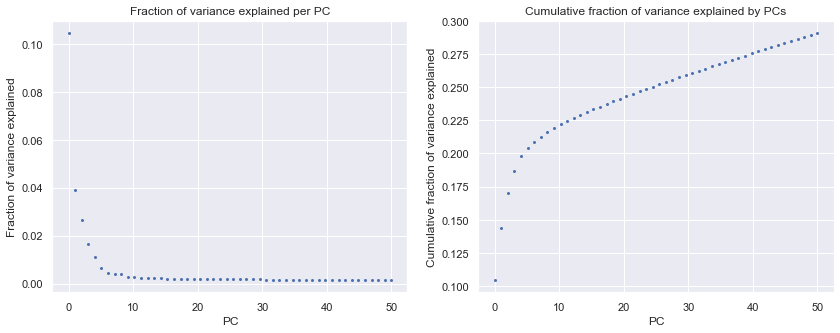

Number of PCs that together explain a fraction of 0.2 of the variance: 5


In [11]:
adata_PP, n_pcs = pca_frac(adata_PP, 0.20, N=50)

In [12]:
# Data is unshuffled; samples are in order
adata_PP.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
120703436113835               2306                 7.743703       10216.0   
120703436351717               2394                 7.781139       10938.0   
120726897253220               1262                 7.141245        2958.0   
120769892956524               1451                 7.280697        4644.0   
120778570709861               1899                 7.549609        7683.0   

                 log1p_total_counts  pct_counts_in_top_50_genes  \
120703436113835            9.231809                   45.193814   
120703436351717            9.300090                   46.690437   
120726897253220            7.992607                   40.635565   
120769892956524            8.443546                   41.279070   
120778570709861            8.946896                   46.895744   

                 pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
120703436113835                    61.100235                    69.655442   
120703436351717                    62.168587                    69.930517   
120726897253220                    50.878972                    59.736308   
120769892956524                    57.859604                    67.334195   
120778570709861                    62.462580                    70.532344   

                 pct_counts_in_top_500_genes  total_counts_mito  \
120703436113835                    78.651135             1274.0   
120703436351717                    79.146096              957.0   
120726897253220                    74.239351              486.0   
120769892956524                    79.521964              395.0   
120778570709861                    80.190030              676.0   

                 log1p_total_counts_mito  pct_counts_mito  total_counts_ribo  \
120703436113835                 7.150702        12.470634             3666.0   
120703436351717                 6.864848         8.749314             4713.0   
120726897253220                 6.188264        16.430019              600.0   
120769892956524                 5.981414         8.505598             1696.0   
120778570709861                 6.517671         8.798646             3131.0   

                 log1p_total_counts_ribo  pct_counts_ribo  \
120703436113835                 8.207129        35.884888   
120703436351717                 8.458292        43.088318   
120726897253220                 6.398595        20.283976   
120769892956524                 7.436617        36.520241   
120778570709861                 8.049427        40.752308   

                 original_total_counts  log10_total_counts  
120703436113835                10216.0            4.009281  
120703436351717                10938.0            4.038938  
120726897253220                 2958.0            3.470998  
120769892956524                 4644.0            3.666892  
120778570709861                 7683.0            3.885531

In [13]:
# Shuffle data before visualization so samples aren't in order
idx = adata_PP.obs.index.values
np.random.shuffle(idx)
adata_PP = adata_PP[idx, :]
adata_PP.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
121963862473526                909                 6.813445        3181.0   
230799420021470               2191                 7.692570        7741.0   
131106671290158               1937                 7.569412        8432.0   
131105431968115               3218                 8.076826       12775.0   
130675115439979                 57                 4.060443          67.0   

                 log1p_total_counts  pct_counts_in_top_50_genes  \
121963862473526            8.065266                   54.353977   
230799420021470            8.954415                   41.286655   
131106671290158            9.039907                   48.185484   
131105431968115            9.455323                   33.667319   
130675115439979            4.219508                   89.552239   

                 pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
121963862473526                    67.745992                    75.950959   
230799420021470                    54.799122                    63.686862   
131106671290158                    63.401328                    71.347249   
131105431968115                    45.902153                    57.322896   
130675115439979                   100.000000                   100.000000   

                 pct_counts_in_top_500_genes  total_counts_mito  \
121963862473526                    87.142408              628.0   
230799420021470                    74.434828              857.0   
131106671290158                    80.621442              816.0   
131105431968115                    69.675147             1166.0   
130675115439979                   100.000000                1.0   

                 log1p_total_counts_mito  pct_counts_mito  total_counts_ribo  \
121963862473526                 6.444131        19.742220             1042.0   
230799420021470                 6.754604        11.070921             2350.0   
131106671290158                 6.705639         9.677419             3474.0   
131105431968115                 7.062191         9.127202             2655.0   
130675115439979                 0.693147         1.492537               10.0   

                 log1p_total_counts_ribo  pct_counts_ribo  \
121963862473526                 6.949856        32.756992   
230799420021470                 7.762596        30.357834   
131106671290158                 8.153350        41.200191   
131105431968115                 7.884576        20.782780   
130675115439979                 2.397895        14.925373   

                 original_total_counts  log10_total_counts  
121963862473526                 3181.0            3.502564  
230799420021470                 7741.0            3.888797  
131106671290158                 8432.0            3.925931  
131105431968115                12775.0            4.106361  
130675115439979                   67.0            1.826075

In [14]:
# save AnnData object
adata_PP.write_h5ad(os.path.join(path_outdir, f"{sample_name}_normalized.h5ad"))

## Cluster with Phenograph

### Display Pairwise Rand Index for k Parameter

In [15]:
adata = sc.read_h5ad(os.path.join(path_outdir, f"{sample_name}_normalized.h5ad"))

In [16]:
adata

AnnData object with n_obs × n_vars = 1183 × 11762
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'original_total_counts', 'log10_total_counts'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'log', 'norm', 'raw'

In [17]:
ks = np.arange(10, 77, 3)  # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k, adata.obsm['X_pca']) for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1117861270904541 seconds
Jaccard graph constructed in 0.09620904922485352 seconds
Wrote graph to binary file in 0.029097795486450195 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.885308
Louvain completed 21 runs in 0.48396730422973633 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.9029030799865723 seconds
Finding 13 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10842299461364746 seconds
Jaccard graph constructed in 0.10819196701049805 seconds
Wrote graph to binary file in 0.05442214012145996 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.875747
After 2 runs, maximum modularity is Q = 0.87839
Louvain completed 22 runs in 0.5923469066619873 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.0600559711456299 s

Neighbors computed in 0.11245489120483398 seconds
Jaccard graph constructed in 0.42475295066833496 seconds
Wrote graph to binary file in 0.37556886672973633 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799038
After 2 runs, maximum modularity is Q = 0.801931
Louvain completed 22 runs in 0.7688279151916504 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.8843798637390137 seconds
Finding 61 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10712289810180664 seconds
Jaccard graph constructed in 0.4939091205596924 seconds
Wrote graph to binary file in 0.24196600914001465 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797418
Louvain completed 21 runs in 0.7466533184051514 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.7818970680236816 seconds
Finding 64 nearest neighbors using minkowski metric and 'auto' algo

In [18]:
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

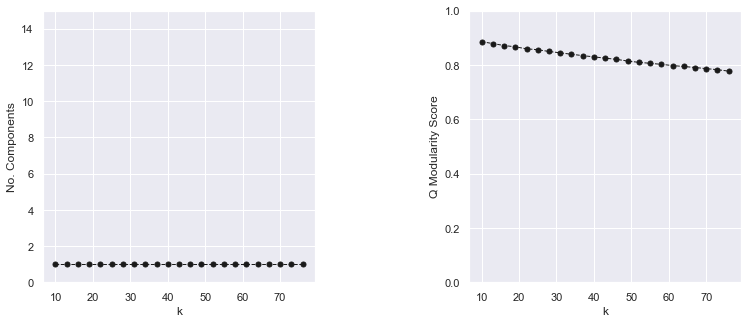

In [19]:
k = cluster_characteristics['k']
no_components = cluster_characteristics['components']
Q = cluster_characteristics['Q']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_box_aspect(1)
ax1.plot(
    k, no_components, color='k', marker='o',
    linestyle='dashed', linewidth=1, markersize=5
)
ax1.set_xlabel('k')
ax1.set_ylabel('No. Components')
ax1.set_ylim(0, 15)

ax2.set_box_aspect(1)
ax2.plot(
    k, Q, color='k', marker='o',
    linestyle='dashed', linewidth=1, markersize=5
)
ax2.set_xlabel('k')
ax2.set_ylabel('Q Modularity Score')
ax2.set_ylim(0, 1)

plt.show()
plt.close()

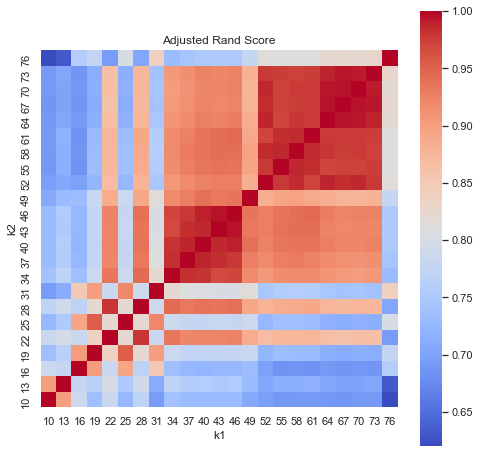

In [20]:
n = len(ks)
Rand_indices = pd.DataFrame(np.zeros((n, n)), index=ks, columns=ks)

Rand_indices.index.name = 'k1'
Rand_indices.columns.name = 'k2'

for i in range(n):
    for j in range(n):
        Rand_indices.iloc[i, j] = adjusted_rand_score(
            cluster_characteristics['communities'][i],
            cluster_characteristics['communities'][j]
        )

plt.figure(figsize=(8, 8))
sbn.heatmap(Rand_indices, cmap=('coolwarm'), square=True).invert_yaxis()
sbn.set(font_scale=1)
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score')
plt.show()
plt.close()

### Search for Robust k

In [22]:
ks

array([10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58,
       61, 64, 67, 70, 73, 76])

Calculating for k: 10... Min. Rand Index is: 0.7001403817674196
Calculating for k: 15.... Min. Rand Index is: 0.6827002188951596
Calculating for k: 20.... Min. Rand Index is: 0.7449998060889298
Calculating for k: 25.... Min. Rand Index is: 0.7540438575451025
Calculating for k: 30.... Min. Rand Index is: 0.7920957393839743
Calculating for k: 35.... Min. Rand Index is: 0.8014990358040027
Calculating for k: 40.... Min. Rand Index is: 0.9439994163602949
Discovered optimal k: 40
Min. Rand Index for 40: 0.9439994163602949


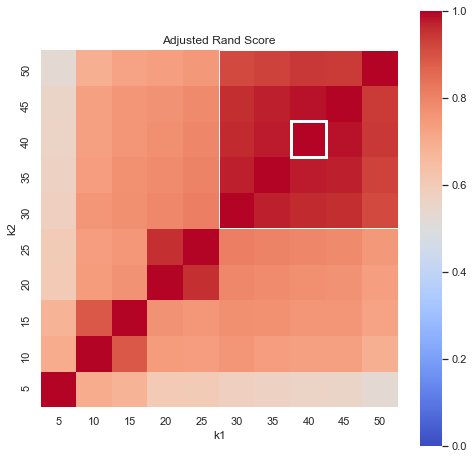

In [23]:
koptimizer = KOptimizer()

k = koptimizer.find_k(
    data = adata.obsm['X_pca'], k0=ks[0],
    verbose=True, display=True
)

In [24]:
k

40

### Choose Robust k

In [25]:
communities, graph, Q = sc.external.tl.phenograph(
    pd.DataFrame(adata.obsm['X_pca']), k=k
)  # run PhenoGraph
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1153721809387207 seconds
Jaccard graph constructed in 0.2973759174346924 seconds
Wrote graph to binary file in 0.2121870517730713 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.829062
Louvain completed 21 runs in 0.5867660045623779 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.4009242057800293 seconds


In [26]:
np.max(communities)

8

### Compute Gene Covariance in Each Cluster

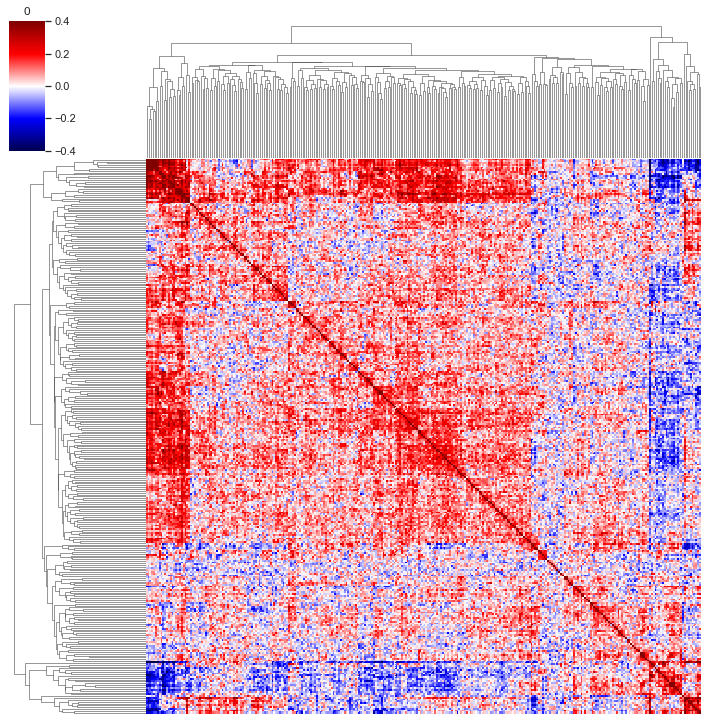

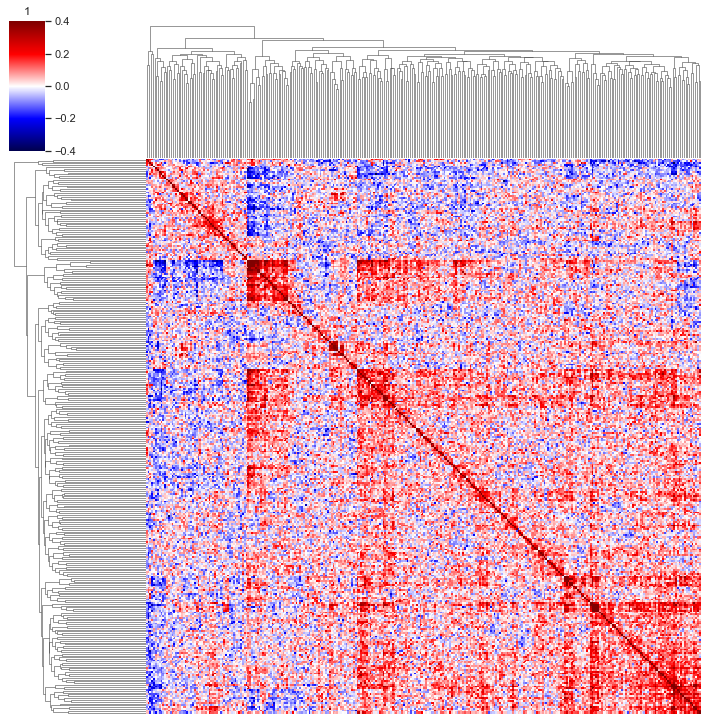

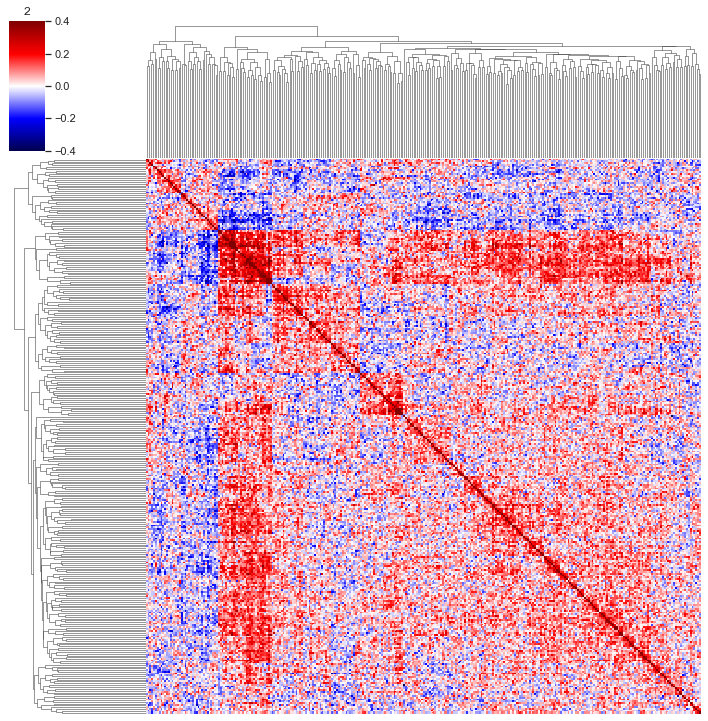

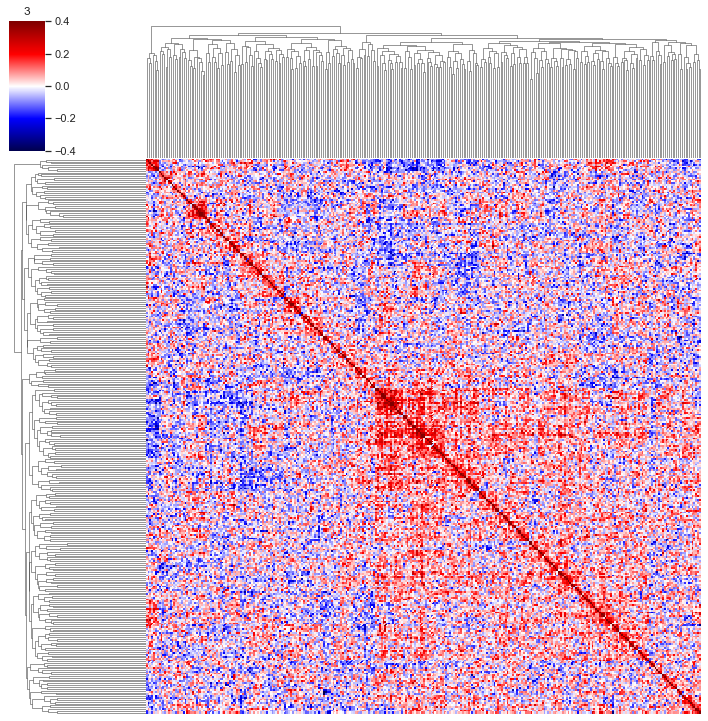

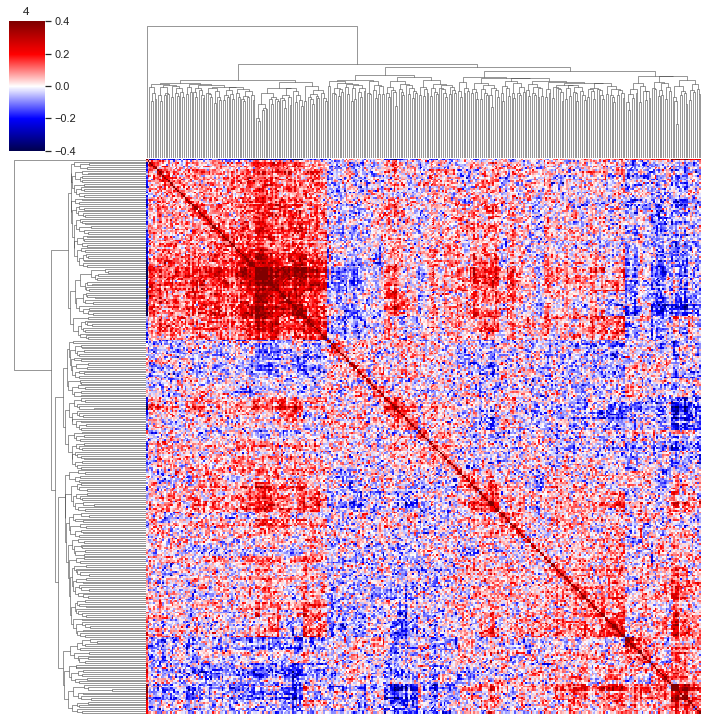

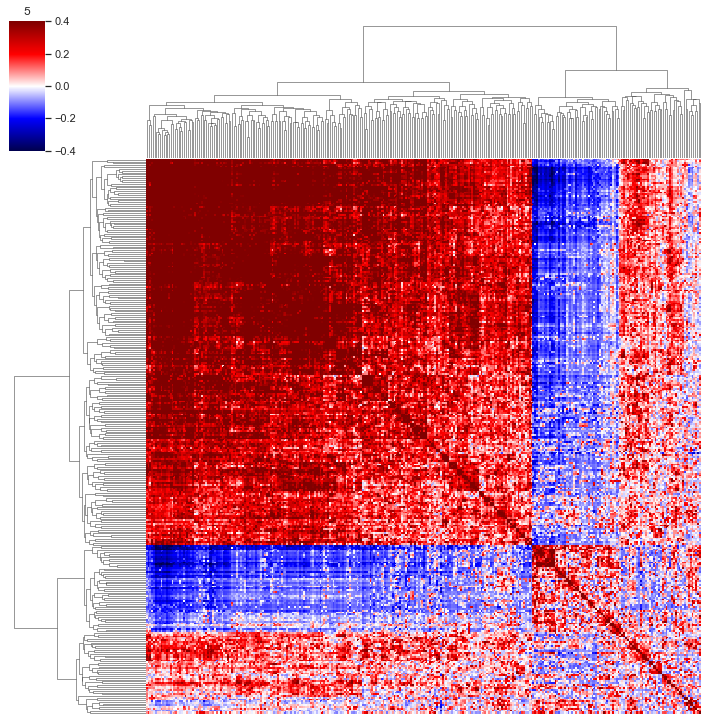

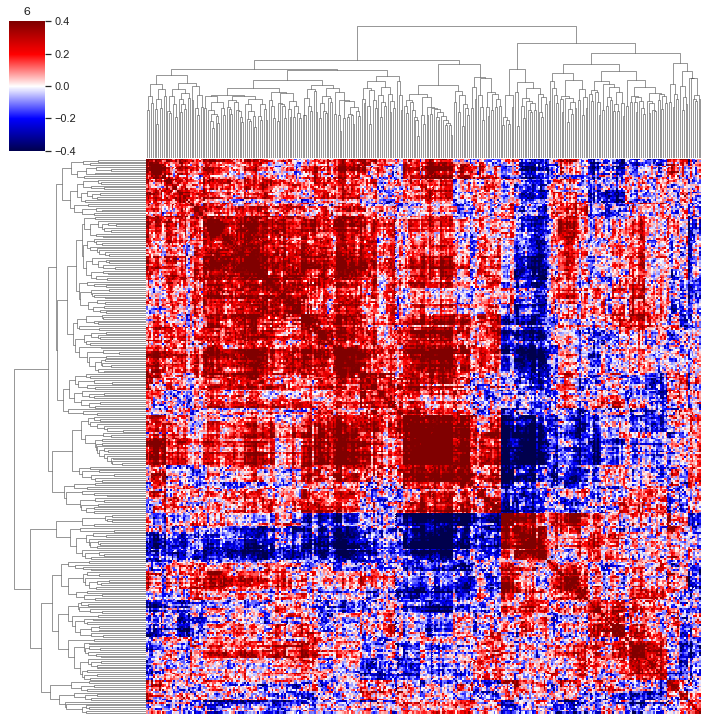

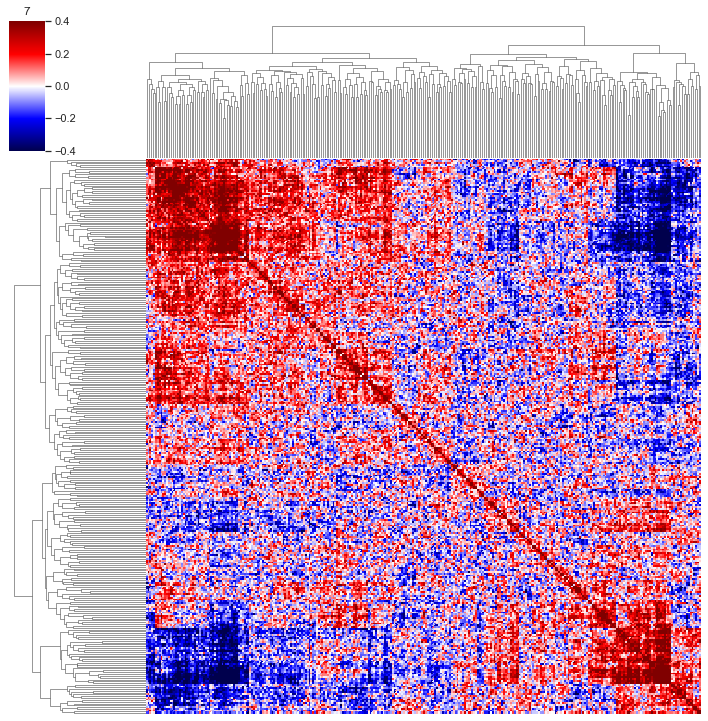

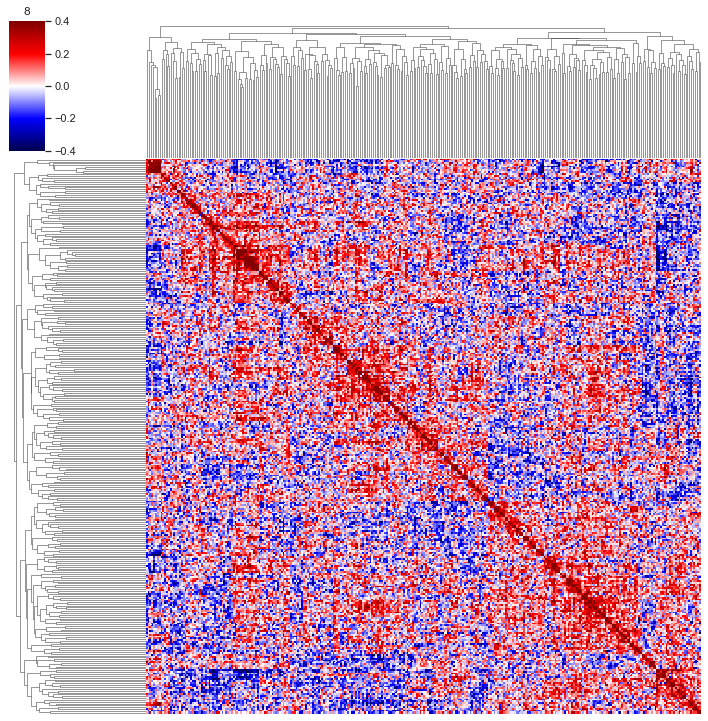

In [27]:
n_genes = 300

# should i parallelize this?
all_clusters = adata.obs.groupby('PhenoGraph_clusters')
for n, group in all_clusters:
    # Get cells in cluster n
    subset = adata[group.index, :]
    # X is a sparse matrix; yields sum of each row
    sums = subset.X.sum(axis=0)
    sums = np.ravel(sums)
    top_genes = np.argsort(sums)[::-1][:n_genes]
#     subset = subset[:, top_genes].X.todense()
    subset = subset[:, top_genes].X
    cov = np.corrcoef(subset.T)
    try:
        tmp = sbn.clustermap(
            cov, cmap='seismic',
            #             row_cluster=False, col_cluster=False,
            yticklabels="", xticklabels="",
            vmax=.4, center=0, vmin=-.4
        )
        plt.title(str(n))
    except:
        1.0

### Remove Bad Clusters (Low Correlation Structure)

## Visualize

In [28]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"
]

### Compute diffusion components

[1.         0.99684215 0.9965359  0.99170536 0.9807721  0.9709041
 0.9571951  0.94731724 0.94389343 0.91759783 0.9154169  0.89671695
 0.88231236]
Number of diffusion components: 12
[0.99684215 0.9965359  0.99170536 0.9807721  0.9709041  0.9571951
 0.94731724 0.94389343 0.91759783 0.9154169  0.89671695 0.88231236]


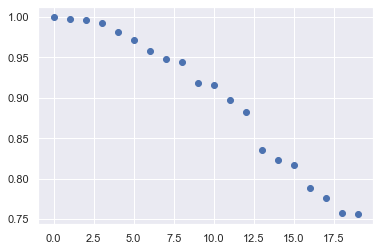

In [29]:
sc.pp.neighbors(adata, method='gauss', use_rep='X_pca')
sc.tl.diffmap(adata, n_comps=20)
eig_vals = adata.uns['diffmap_evals']
# print(eig_vals)
plt.scatter(x=list(range(len(eig_vals))), y=eig_vals)

# Pick diffusion components until greatest dropoff in eigenvalues
no_eigs = np.argsort(eig_vals[:(len(eig_vals)-1)] - eig_vals[1:])[-1] + 1
#sc.tl.diffmap(adata, n_comps=no_eigs)
adata.obsm['X_diffmap'] = adata.obsm['X_diffmap'][:, :no_eigs]
adata.uns['diffmap_evals'] = adata.uns['diffmap_evals'][:no_eigs]
eig_vals = adata.uns['diffmap_evals']
print(eig_vals)

# Remove first component (eigenvalue = 1.0)
adata.obsm['X_diffmap'] = adata.obsm['X_diffmap'][:, 1:]
adata.uns['diffmap_evals'] = adata.uns['diffmap_evals'][1:]
print('Number of diffusion components: '+str(no_eigs-1))

print(adata.uns['diffmap_evals'])
# print(pd.DataFrame(adata.obsm['X_diffmap']))

adata.obs['DC 1'] = adata.obsm['X_diffmap'][:, 0]
adata.obs['DC 2'] = adata.obsm['X_diffmap'][:, 1]
adata.obs['DC 3'] = adata.obsm['X_diffmap'][:, 2]

### UMAP with PCs

In [30]:
sc.pp.neighbors(adata, method='umap', use_rep='X_pca')
sc.tl.umap(adata, random_state=None)

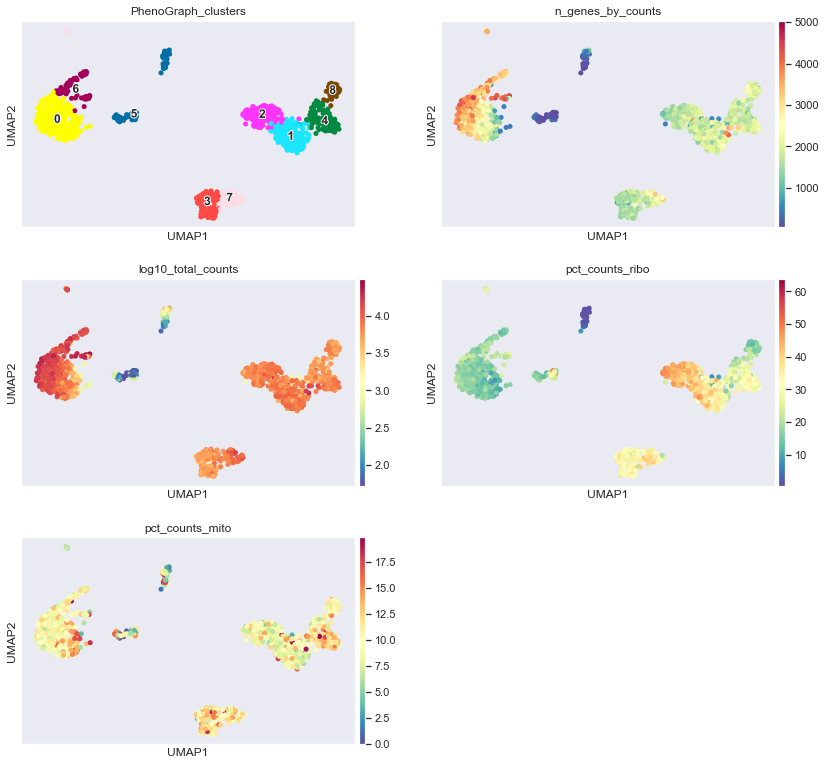

In [31]:
sc.pl.umap(
    adata,
    color=['PhenoGraph_clusters', 'n_genes_by_counts', 'log10_total_counts',
           'pct_counts_ribo', 'pct_counts_mito'] + markers,
    ncols=2,
    sort_order=False,
    palette=sc.pl.palettes.godsnot_102,  # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)

### UMAP with DCs

In [32]:
sc.pp.neighbors(adata, method='umap', use_rep='X_diffmap')
sc.tl.umap(adata, random_state=None)

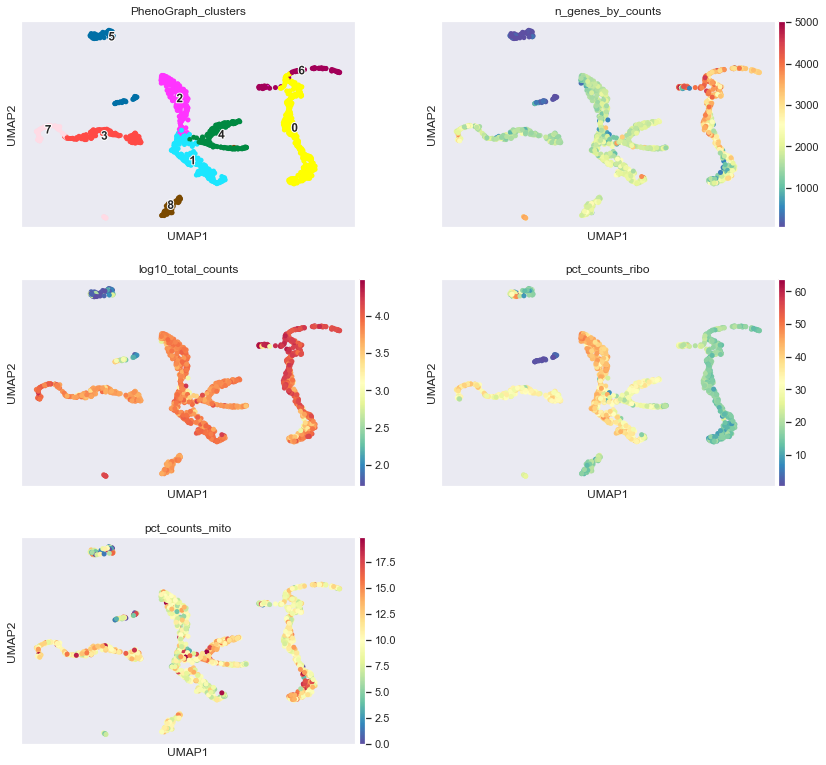

In [33]:
sc.pl.umap(
    adata,
    color=['PhenoGraph_clusters', 'n_genes_by_counts',
           'log10_total_counts', 'pct_counts_ribo', 'pct_counts_mito'],
    ncols=2,
    sort_order=False,
    palette=sc.pl.palettes.godsnot_102,  # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)

### TSNE with PCs

In [34]:
sc.tl.tsne(adata, use_rep='X_pca', n_jobs=-1)

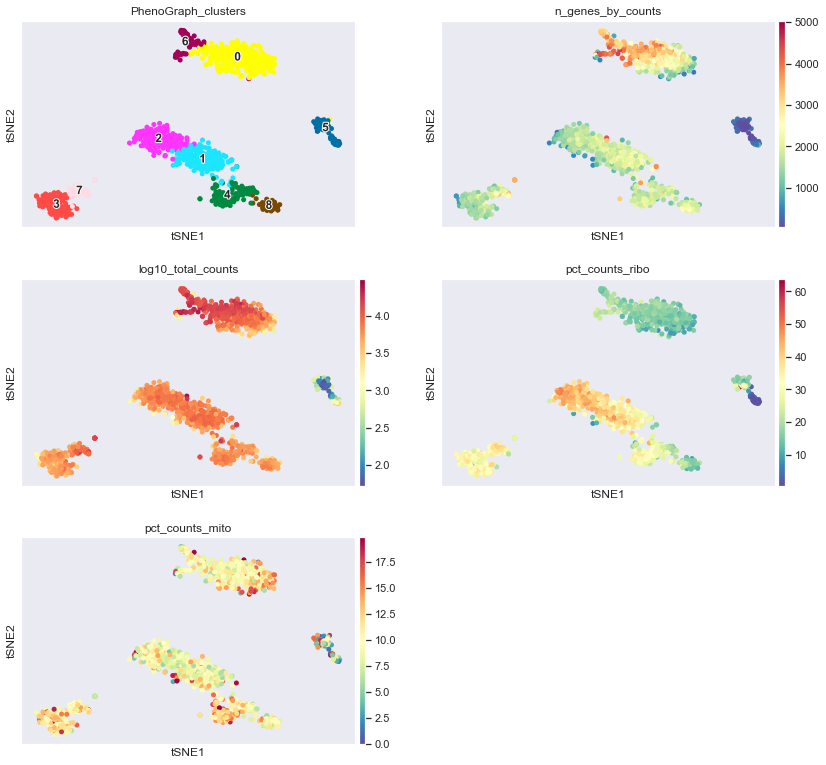

In [35]:
sc.pl.tsne(
    adata,
    color=['PhenoGraph_clusters', 'n_genes_by_counts', 'log10_total_counts',
           'pct_counts_ribo', 'pct_counts_mito'] + markers,
    ncols=2,
    sort_order=False,
    palette=godsnot_64,  # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)

### TSNE with DCs

In [36]:
sc.tl.tsne(adata, use_rep='X_diffmap', n_jobs=-1)

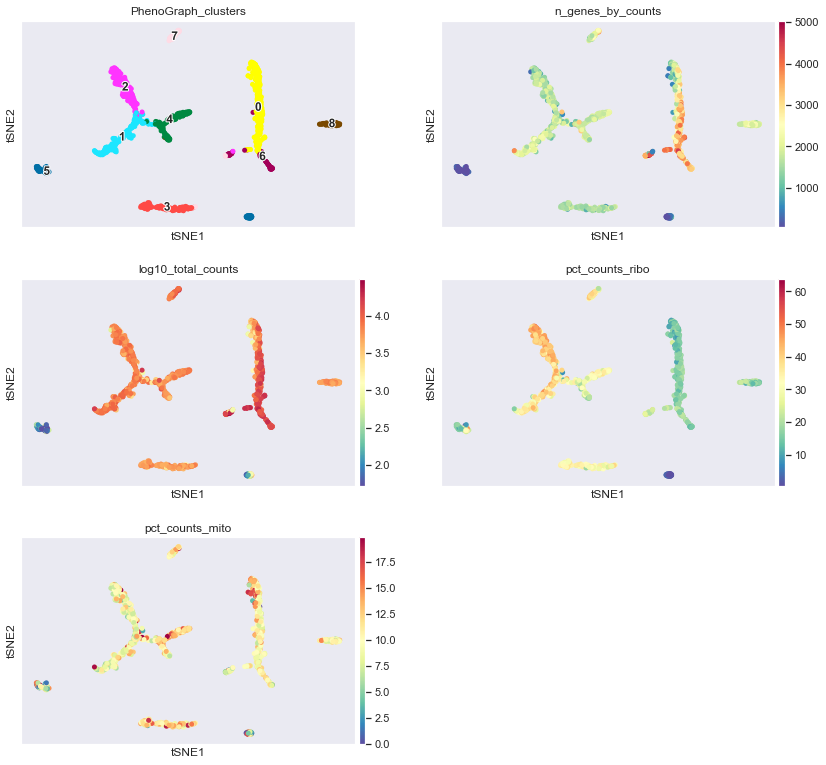

In [37]:
sc.pl.tsne(
    adata,
    color=['PhenoGraph_clusters', 'n_genes_by_counts', 'log10_total_counts',
           'pct_counts_ribo', 'pct_counts_mito'] + markers,
    ncols=2,
    sort_order=False,
    palette=godsnot_64,  # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)

### Force-directed layout with PCs

In [38]:
sc.pp.neighbors(adata, method='gauss', use_rep='X_pca')
sc.tl.draw_graph(adata)

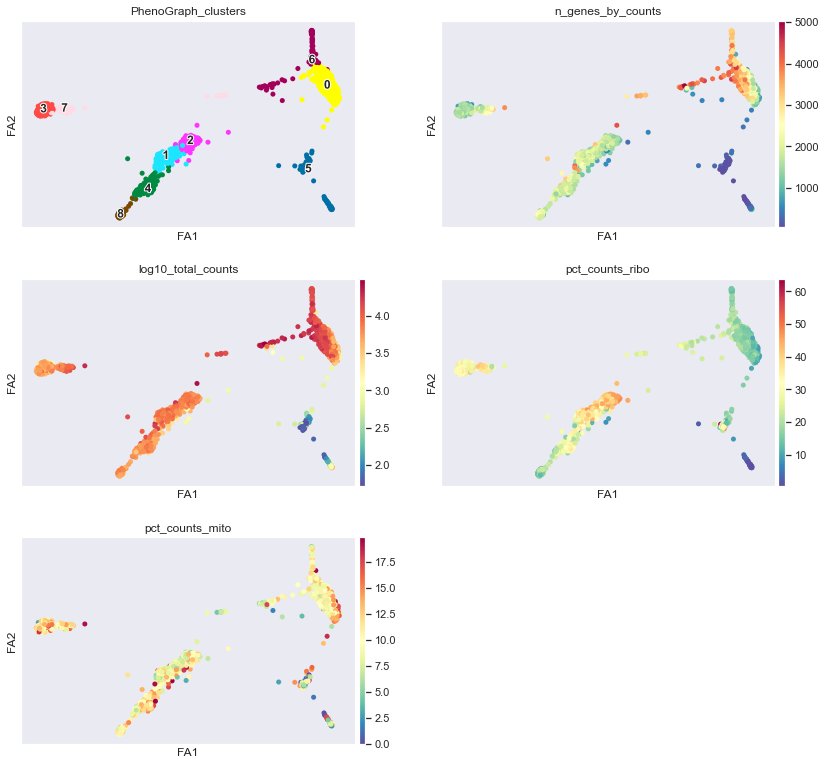

In [39]:
sc.pl.draw_graph(
    adata,
    color=['PhenoGraph_clusters', 'n_genes_by_counts', 'log10_total_counts',
           'pct_counts_ribo', 'pct_counts_mito'],
    ncols=2,
    sort_order=False,
    palette=sc.pl.palettes.godsnot_102,  # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)

### Force-directed layout with DCs

In [40]:
sc.pp.neighbors(adata, method='gauss', use_rep='X_diffmap')
sc.tl.draw_graph(adata)

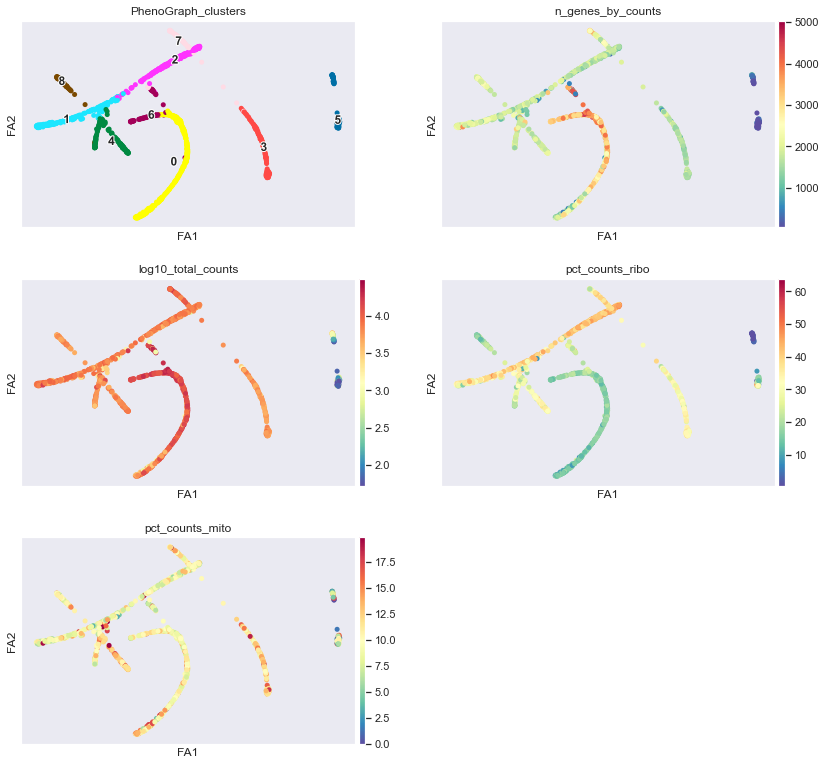

In [41]:
sc.pl.draw_graph(
    adata,
    color=['PhenoGraph_clusters', 'n_genes_by_counts', 'log10_total_counts',
           'pct_counts_ribo', 'pct_counts_mito'],
    ncols=2,
    sort_order=False,
    palette=sc.pl.palettes.godsnot_102,  # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)

In [42]:
adata.write_h5ad(os.path.join(path_outdir, f"{sample_name}_visualized.h5ad"))